In [2]:
# Import necessary modules and functions

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
cols = ['project_id', 'blurb', 'category', 'country', 'created_at', 'currency', 'deadline', 'fx_rate', 'goal',
'launched_at', 'name', 'staff_pick', 'location', 'subcategory', 'project_url', 'reward_url']

In [3]:
df = pd.read_csv('KS_train_data.csv', delimiter=',')
#df_test = pd.read_csv('KS_test_data.csv', delimiter=';')

In [4]:
df.columns

Index(['project_id', 'backers_count', 'blurb', 'category',
       'converted_pledged_amount', 'country', 'created_at', 'currency',
       'deadline', 'fx_rate', 'goal', 'launched_at', 'name', 'pledged',
       'staff_pick', 'usd_pledged', 'location', 'funded', 'subcategory',
       'project_url', 'reward_url'],
      dtype='object')

In [5]:
print(datetime.fromtimestamp(df.iloc[1].created_at))

2012-03-05 06:41:24


In [6]:
df['delta_time_created'] = df.deadline - df.created_at
df['delta_time_launched'] = df.deadline - df.launched_at

<AxesSubplot:xlabel='delta_time_launched_days'>

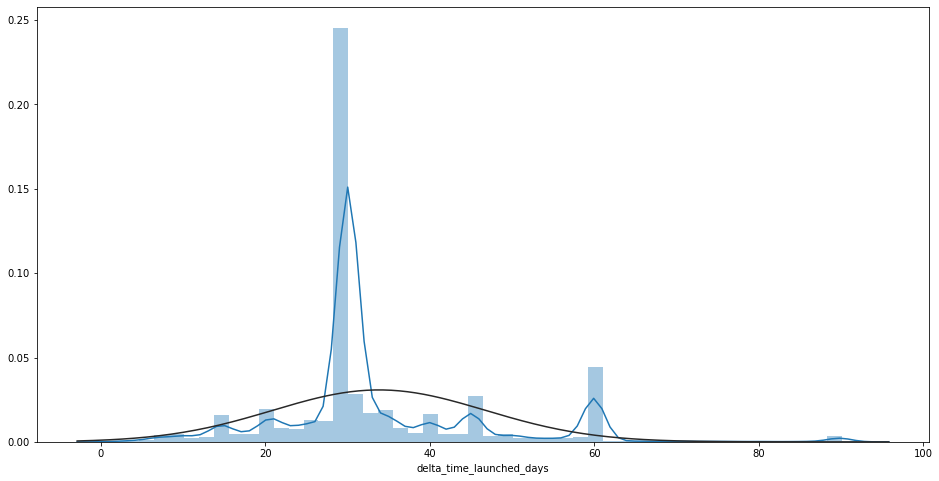

In [7]:
df['delta_time_launched_days'] = df.delta_time_launched / 86400
df['delta_time_created_days'] = df.delta_time_launched / 86400

sns.distplot(df.delta_time_launched_days, fit=norm)


In [8]:
df[cols].info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   project_id   100000 non-null  object 
 1   blurb        99998 non-null   object 
 2   category     100000 non-null  object 
 3   country      99997 non-null   object 
 4   created_at   100000 non-null  int64  
 5   currency     100000 non-null  object 
 6   deadline     100000 non-null  int64  
 7   fx_rate      100000 non-null  float64
 8   goal         100000 non-null  float64
 9   launched_at  100000 non-null  int64  
 10  name         99999 non-null   object 
 11  staff_pick   100000 non-null  bool   
 12  location     100000 non-null  object 
 13  subcategory  100000 non-null  object 
 14  project_url  100000 non-null  object 
 15  reward_url   100000 non-null  object 
dtypes: bool(1), float64(2), int64(3), object(10)
memory usage: 11.5+ MB


NameError: name 'df_test' is not defined

In [9]:
total_funded = df.loc[(df.funded==True), 'funded'].value_counts()

In [10]:
funded_staff_pick = df.loc[(df.funded==True) & (df.staff_pick == True), 'staff_pick'].value_counts() / total_funded
funded_staff_pick
# means that about 80% of those funded were not staff picked


True    0.213553
dtype: float64

<AxesSubplot:>

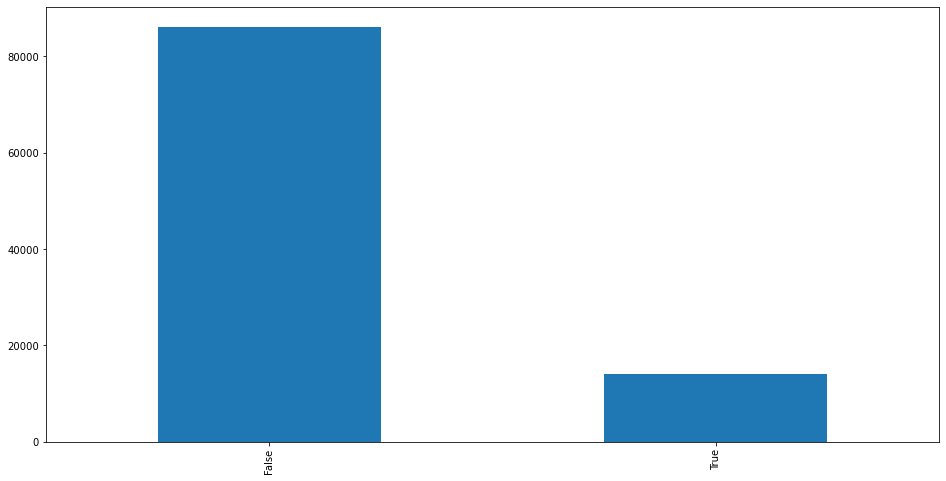

In [11]:
df['staff_pick'].value_counts().plot(kind='bar')

In [12]:
df['goal_converted_log'] = np.log(df.goal * df.fx_rate)


Text(0.5, 1.0, 'Funded vs unfunded converted log goals')

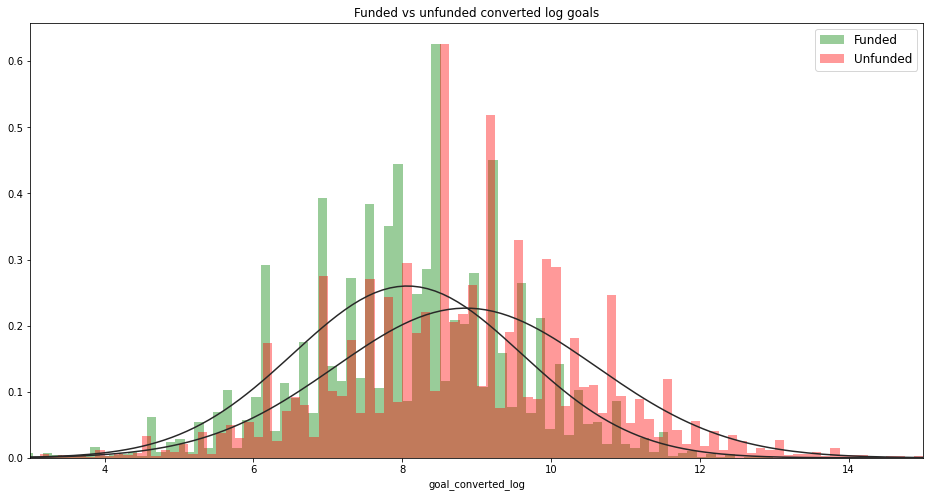

In [13]:
funded = df.loc[df.funded == True]
not_funded = df.loc[df.funded == False]

dplot = sns.distplot(funded.goal_converted_log, kde=False, color='green', bins=150, hist=True, fit=norm, label='Funded')
dplot = sns.distplot(not_funded.goal_converted_log, kde=False, color='red', bins=150, hist=True, fit=norm, label='Unfunded')
dplot.set(xlim=(3,15))
dplot.legend(prop={'size': 12})
dplot.set_title('Funded vs unfunded converted log goals')

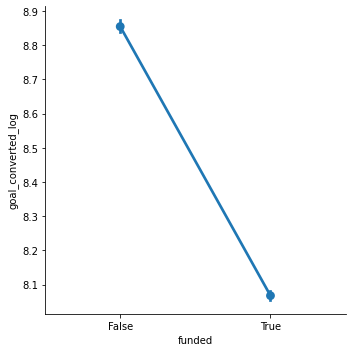

In [14]:
sns.catplot(data=df, x ='funded', y='goal_converted_log', kind='point')

In [15]:
df['goal_per_day'] = df['goal_converted_log'] / df['delta_time_launched']

Text(0.5, 1.0, 'Funded vs unfunded projects by log $/day needed to reach goal')

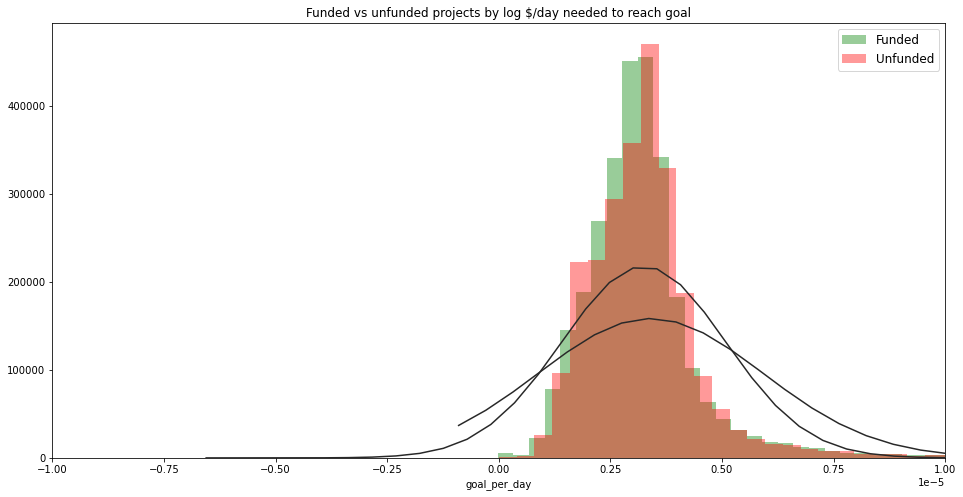

In [16]:
funded = df.loc[df.funded == True]
not_funded = df.loc[df.funded == False]

dplot = sns.distplot(funded.goal_per_day, kde=False, color='green', bins=300, hist=True, fit=norm, label='Funded')
dplot = sns.distplot(not_funded.goal_per_day, kde=False, color='red', bins=300, hist=True, fit=norm, label='Unfunded')
dplot.set(xlim=(-0.00001,.00001))
dplot.legend(prop={'size': 12})
dplot.set_title('Funded vs unfunded projects by log $/day needed to reach goal')

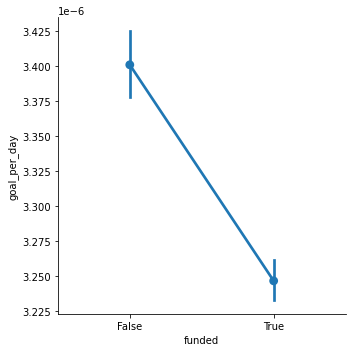

In [17]:
sns.catplot(data=df, x ='funded', y='goal_per_day', kind='point')

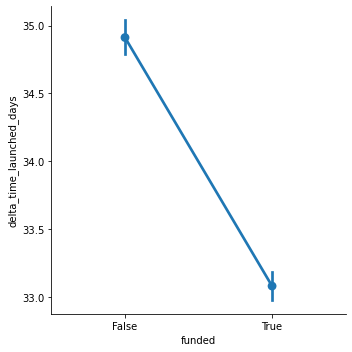

In [18]:
sns.catplot(data=df, x ='funded', y='delta_time_launched_days', kind='point')

In [19]:
# normalize category data
total_in_cat = {}
funded_in_cat = {}
rate_funded_cat = {}
for x in df.category.unique():
    total_in_cat[x] = df.loc[(df.category == x, 'project_id')].count()
    funded_in_cat[x] = df.loc[(df.category == x) & (df.funded == True), 'project_id'].count() 
    rate_funded_cat[x] = funded_in_cat[x] / total_in_cat[x]


In [20]:
rate_funded_cat

{'art': 0.5587666731103809,
 'comics': 0.7601941747572816,
 'crafts': 0.513431934802294,
 'dance': 0.8504453820909517,
 'design': 0.7249434815373021,
 'fashion': 0.44222571236257574,
 'film & video': 0.618456476218965,
 'food': 0.36252280427417255,
 'games': 0.6277122842986502,
 'journalism': 0.3084886128364389,
 'music': 0.6800056461288729,
 'photography': 0.5552989479086476,
 'publishing': 0.7209627484270449,
 'technology': 0.3862853863810253,
 'theater': 0.7510548523206751}

<BarContainer object of 15 artists>

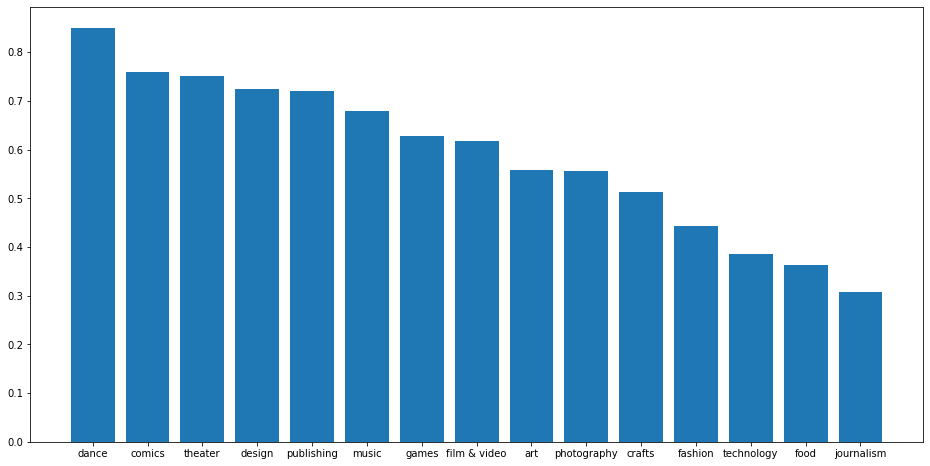

In [21]:
sorted_rate_funded_cat = sorted(rate_funded_cat.items(), key=lambda x: x[1], reverse=True)
plt.bar([x[0] for x in sorted_rate_funded_cat], [y[1] for y in sorted_rate_funded_cat])
#plt.bar(rate_funded_cat.keys(), rate_funded_cat.values())

In [22]:
df['rate_funded_cat'] = df.apply(lambda row: rate_funded_cat[row.category], axis=1)

In [23]:
df.loc[df.category == 'art', 'subcategory'].unique()

array(['mixed media', 'public art', 'sculpture', 'art', 'painting',
       'conceptual art', 'digital art', 'performance art', 'illustration',
       'ceramics', 'installations', 'video art', 'textiles'], dtype=object)

In [24]:
total_in_subcat = {}
funded_in_subcat = {}
rate_funded_subcat = {}
for x in df.subcategory.unique():
    total_in_subcat[x] = df.loc[(df.subcategory == x, 'project_id')].count()
    funded_in_subcat[x] = df.loc[(df.subcategory == x) & (df.funded == True), 'project_id'].count() 
    rate_funded_subcat[x] = funded_in_subcat[x] / total_in_subcat[x]

<BarContainer object of 158 artists>

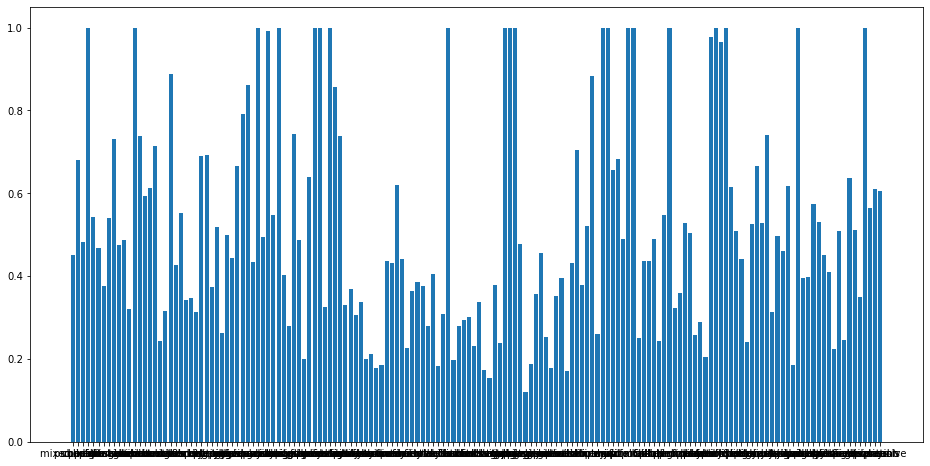

In [25]:
plt.bar(rate_funded_subcat.keys(), rate_funded_subcat.values())

In [26]:
total_in_subcat
#sorted_rate_funded_country

{'mixed media': 1482,
 'public art': 1481,
 'sculpture': 1063,
 'art': 336,
 'painting': 1460,
 'conceptual art': 605,
 'digital art': 705,
 'performance art': 1209,
 'illustration': 1348,
 'ceramics': 168,
 'installations': 250,
 'video art': 100,
 'comics': 1088,
 'comic books': 1365,
 'webcomics': 360,
 'graphic novels': 1013,
 'anthologies': 416,
 'events': 411,
 'textiles': 139,
 'crafts': 722,
 'woodworking': 791,
 'stationery': 165,
 'crochet': 105,
 'embroidery': 69,
 'diy': 665,
 'pottery': 74,
 'knitting': 146,
 'printing': 123,
 'quilts': 52,
 'candles': 258,
 'glass': 76,
 'weaving': 61,
 'taxidermy': 6,
 'performances': 918,
 'residencies': 65,
 'spaces': 481,
 'product design': 1902,
 'graphic design': 1120,
 'dance': 899,
 'workshops': 117,
 'design': 176,
 'civic design': 164,
 'architecture': 364,
 'typography': 66,
 'accessories': 1298,
 'interactive design': 189,
 'apparel': 1283,
 'shorts': 1698,
 'film & video': 146,
 'animation': 1276,
 'documentary': 1687,
 'narr

In [27]:
# needs to be fixed - think it's the null values in country that need to be dropped first
#total_in_country = {}
#funded_in_country = {}
#rate_funded_country = {}
#for x in df.country.unique():
#     total_in_country[x] = df.loc[(df.country == x, 'project_id')].count()
#     funded_in_country[x] = df.loc[(df.country == x) & (df.funded == True), 'project_id'].count() 
#     rate_funded_country[x] = funded_in_country[x] / total_in_country[x]
# sorted_rate_funded_country = sorted(rate_funded_country.items(), key=lambda x: x[1], reverse=True)
# plt.bar([x[0] for x in sorted_rate_funded_country], [y[1] for y in sorted_rate_funded_country])

In [28]:
dum_df = pd.get_dummies(df, columns=["category"], prefix=["cat_typ"] )


In [29]:
cols = ['cat_typ_art', 'cat_typ_comics', 'cat_typ_crafts',
       'cat_typ_dance', 'cat_typ_design', 'cat_typ_fashion',
       'cat_typ_film & video', 'cat_typ_food', 'cat_typ_games',
       'cat_typ_journalism', 'cat_typ_music', 'cat_typ_photography',
       'cat_typ_publishing', 'cat_typ_technology', 'cat_typ_theater', 'rate_funded_cat', 'delta_time_launched_days', 'goal_converted_log', 'staff_pick']
x_train, x_test, y_train, y_test = train_test_split(dum_df[cols], dum_df['funded'], test_size =0.80, random_state=0)
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr.C = 0.01
lgr.fit(x_train, y_train)
score = lgr.score(x_test, y_test)
predictions = lgr.predict(x_test)
print(score)

0.704125


[[17092 16171]
 [ 7499 39238]]


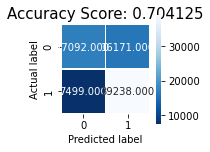

In [30]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [31]:
lgr.get_params()

{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [32]:
lgr.solver='newton-cg'
lgr.c = 1
lgr.fit(x_train, y_train)
score = lgr.score(x_test, y_test)
predictions = lgr.predict(x_test)
print(score)

0.70425


In [33]:
from sklearn import preprocessing
lgr.solver='lbfgs'
rb_scaler = preprocessing.RobustScaler()
x_train_rb = rb_scaler.fit_transform(x_train)
rb_scaler.transform(x_test)
lgr.fit(x_train_rb, y_train)
predictions = lgr.predict(x_test)
score = lgr.score(x_test, y_test)
print(score)

0.416175


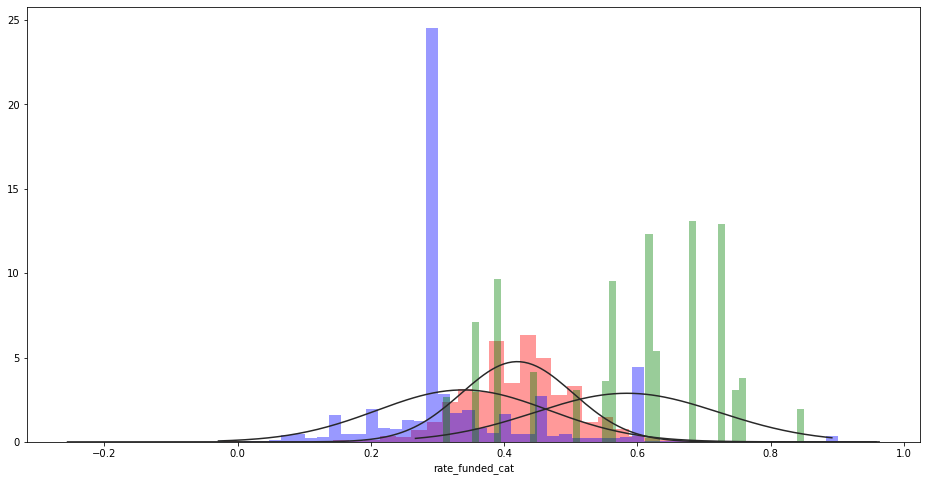

In [34]:
dplot = sns.distplot((df['goal_converted_log'])/20, color='red', kde=False, fit=norm)
dplot = sns.distplot(df['delta_time_launched_days']/100, color='blue', kde=False, fit=norm)
dplot = sns.distplot(df['rate_funded_cat'], color='green', kde=False, fit=norm)


In [35]:
dum_df['goal_scaled'] = df.goal_converted_log / 20
dum_df['time_scaled'] = df.delta_time_launched_days / 100

In [61]:
cols = ['cat_typ_art', 'cat_typ_comics', 'cat_typ_crafts',
       'cat_typ_dance', 'cat_typ_design', 'cat_typ_fashion',
       'cat_typ_film & video', 'cat_typ_food', 'cat_typ_games',
       'cat_typ_journalism', 'cat_typ_music', 'cat_typ_photography',
       'cat_typ_publishing', 'cat_typ_technology', 'cat_typ_theater', 
        'rate_funded_cat', 'delta_time_launched_days', 'goal_converted_log', 'staff_pick']
x_train, x_test, y_train, y_test = train_test_split(dum_df[cols], dum_df['funded'], test_size =0.80, random_state=0)
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr.C = 1e3
lgr.fit_intercept = False
lgr.solver='newton-cg'
lgr.fit(x_train, y_train)
score = lgr.score(x_test, y_test)
predictions = lgr.predict(x_test)
print(score)

0.7061125
